# EMIT L2A Reflectance – end‑to‑end example
This notebook follows the same **flow** as your original: setup → search → pick → download → open/flatten → mask → (optional) orthorectify → visualize → (optional) export/merge.

It uses the refactored helpers in `emitref/` plus your original `emit_tools` (vendored in the package).

## 1) Environment & imports

In [1]:
! pip install -r requirements.txt

In [2]:
# If you unzipped the package next to this notebook, ensure Python can import it.
# Adjust the path below if needed.
import sys, pathlib
p = pathlib.Path().resolve()
# Example: sys.path.append(str(p / "emitref_refactor_with_emit_tools"))
# If you've installed as a package (pip -e .), you can skip sys.path fiddling.

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# interactive (optional)
import hvplot.xarray  # noqa: F401
import holoviews as hv
hv.extension('bokeh')

from datetime import datetime, timezone, timedelta

# Our helpers
from EMIT_data.EMIT_utils import (
login, search, choose_nearest, download_reflectance,
open_reflectance, attach_wavelengths
)
from EMIT_data.geo import get_pixel_center_coords, apply_glt, ortho_xr
from EMIT_data.viz import plot_band_nm, rgb_from_nm, hv_quicklook
from EMIT_data.emit_tools import (
    quality_mask, band_mask,
    spatial_subset,
    ortho_xr 
)


In [9]:
LAT = 50.3794
LON = 43.1656
DATE = "2024-06-04"
DAYS_BEFORE = 5
DAYS_AFTER  = 5
SEARCH_BUFFER_M = 5000    

target_dt = datetime(2024, 6, 4, tzinfo=timezone.utc)  # center date
start = target_dt - timedelta(days=DAYS_BEFORE)
end   = target_dt + timedelta(days=DAYS_AFTER)

print(start, "→", end)


2024-05-30 00:00:00+00:00 → 2024-06-09 00:00:00+00:00


In [10]:
# This opens a browser/device-code flow on first run and caches your token (persist=True)
login(persist=True)


## 4) Search EMIT L2A reflectance and pick nearest granule

In [11]:
picks = search(point=(LON, LAT), buffer_m=SEARCH_BUFFER_M, start=None, end=None, cloud_cover = (0.0,100.0))

Found 12 granule(s).


In [18]:
picks = search(point=(LON, LAT), buffer_m=SEARCH_BUFFER_M, start=None, end=None, cloud_cover = (0.0,0.1))

Found 1 granule(s).


In [19]:
picks[0].keys()

dict_keys(['meta', 'umm', 'size'])

In [20]:
picks[0]["umm"]["ProviderDates"][0]["Date"]

'2024-04-12T08:51:59Z'

In [22]:
pick = choose_nearest(picks, target_dt)
if pick is None:
    raise SystemExit("No EMIT granules found in the window.")
pick

Collection: {'ShortName': 'EMITL2ARFL', 'Version': '001'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 44.23533248901367, 'Latitude': 51.0675048828125}, {'Longitude': 42.892940521240234, 'Latitude': 50.85906219482422}, {'Longitude': 43.00783157348633, 'Latitude': 50.119117736816406}, {'Longitude': 44.350223541259766, 'Latitude': 50.32756042480469}, {'Longitude': 44.23533248901367, 'Latitude': 51.0675048828125}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-04-11T07:45:34Z', 'EndingDateTime': '2024-04-11T07:45:46Z'}}
Size(MB): 3579.4060192108154
Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240411T074534_2410205_001/EMIT_L2A_RFL_001_20240411T074534_2410205_001.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240411T074534_2410205_001/EMIT_L2A_MASK_001_20240411T074534_2410205_001.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240411T074534_2410205_001/EMIT_L2A_RFLUNCERT_001_20240411T074534_2410205_001.nc']

## 5) Download reflectance (NetCDF)

In [23]:
from pathlib import Path
out_dir = Path("data/emit")
paths = download_reflectance(pick, out_dir, assets=['_RFL_'])
paths

Filtered to 1 reflectance-related asset link(s).


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[PosixPath('data/emit/EMIT_L2A_RFL_001_20240411T074534_2410205_001.nc')]

In [ ]:
ds = open_reflectance(paths[0], engine='h5netcdf')      
ds = attach_wavelengths(ds)           
ds


<xarray.Dataset> Size: 2GB
Dimensions:      (downtrack: 1280, crosstrack: 1242, bands: 285)
Dimensions without coordinates: downtrack, crosstrack, bands
Data variables:
    reflectance  (downtrack, crosstrack, bands) float32 2GB ...
Attributes: (12/38)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    southernmost_latitude:             50.15455767203549
    spatialResolution:                 0.000542232520256367
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [ 4.28924851e+01  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...

In [25]:
mask_paths = download_reflectance(pick, out_dir, assets=['_MASK_'])

Filtered to 1 reflectance-related asset link(s).


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
from EMIT_data.emit_tools import emit_xarray

In [27]:
qmask = quality_mask(mask_paths[0], quality_bands=[0,1,2,3,4])
bmask = band_mask(mask_paths[0])  

ds_emit = emit_xarray(paths[0], ortho=True, engine="netcdf4")

Flags used: ['Cloud flag' 'Cirrus flag' 'Water flag' 'Spacecraft Flag'
 'Dilated Cloud Flag']


In [28]:
ds_emit['wavelengths'].values.shape

(285,)

In [29]:
ds_vis = ds_emit


In [30]:
rfl_var = "reflectance" if "reflectance" in ds_vis.data_vars else list(ds_vis.data_vars)[0]
ds_vis[rfl_var].dims

('latitude', 'longitude', 'wavelengths')

In [31]:
from EMIT_data.viz import hv_quicklook_nearest_valid, emit_quicklook_matplotlib

In [32]:
import hvplot.xarray
import jupyter_bokeh
import holoviews as hv, panel as pn
pn.extension(comms='colab')
hv.extension('bokeh')

<Axes: title={'center': 'EMIT True Color ~ 664/559/492 nm'}>

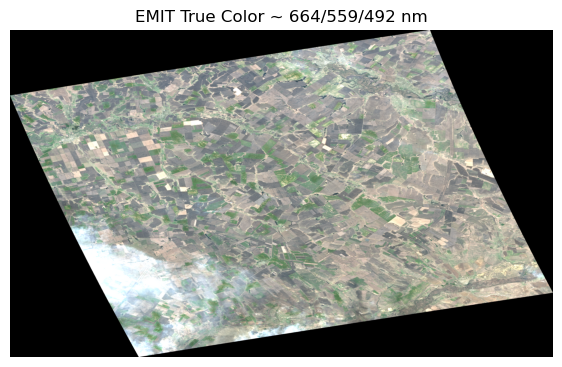

In [36]:
emit_quicklook_matplotlib(ds_vis, white_balance=False, gamma = 1)
